In [30]:
# Graph Neural Networks detection & localization, using only voltage mag & ang
%load_ext autoreload
%autoreload 2

from utils import *
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

DATA_FRAC = 1.0
IS_REDUCED = DATA_FRAC < 0.3

adj = load_adj_matrix('topology.csv')
centrality = np.sum(adj, axis=1, keepdims=True)
centrality = centrality / (centrality.max() + 1e-8) # normalize

def load_day_data(pkl):
    with open(pkl, 'rb') as f:
        data = pickle.load(f)

    v_sch, t_sch = data['sch_v'], data['sch_θ']
    v_att, t_att = data['attack_v'], data['attack_θ']

    att_nodes = [n - 1 for n in data['esset_btm']['A']] # label 1 for attacked, 0 for normal
    att_window = data['timeset_a']['A']
    steps = [f"x{i}" for i in range(min(att_window), max(att_window))]
    if len(steps) == 0:
        return None

    V_sch = np.array([v_sch[s] for s in steps]).T
    T_sch = np.array([t_sch[s] for s in steps]).T
    V_att = np.array([v_att.get(s, v_sch[s]) for s in steps]).T
    T_att = np.array([t_att.get(s, t_sch[s]) for s in steps]).T
    dV, dT = V_att - V_sch, T_att - T_sch

    # percentiles capture distribution shape better than just mean/std
    X = np.concatenate([
        dV.mean(axis=1, keepdims=True), dV.std(axis=1, keepdims=True),
        dT.mean(axis=1, keepdims=True), dT.std(axis=1, keepdims=True),
        V_sch.mean(axis=1, keepdims=True), V_sch.std(axis=1, keepdims=True),
        T_sch.mean(axis=1, keepdims=True), T_sch.std(axis=1, keepdims=True),
        np.abs(dV).max(axis=1, keepdims=True), np.abs(dT).max(axis=1, keepdims=True),
        np.abs(dV).min(axis=1, keepdims=True), np.abs(dT).min(axis=1, keepdims=True),
        np.percentile(np.abs(dV), 75, axis=1, keepdims=True),  # 75th percentile
        np.percentile(np.abs(dT), 75, axis=1, keepdims=True),
        np.percentile(np.abs(dV), 25, axis=1, keepdims=True),  # 25th percentile
        np.percentile(np.abs(dT), 25, axis=1, keepdims=True),
        (np.abs(dV) > np.abs(dV).std(axis=1, keepdims=True) * 2).sum(axis=1, keepdims=True).astype(float),  # outlier count
        (np.abs(dT) > np.abs(dT).std(axis=1, keepdims=True) * 2).sum(axis=1, keepdims=True).astype(float),
        centrality
    ], axis=1)

    y = np.zeros(N_NODES, dtype=np.float32)
    for node in att_nodes:
        y[node] = 1.0

    return X, y

print(f"FDIA detection | only voltage available\n")
print(f"Grid topology: {N_NODES}-bus, {int(np.sum(adj)) // 2}-edge") # edges includes transformers & switches
np.random.seed(20)

# base training data (v1-v3)
X_base, y_base, d_base = load_all_days(DATA_TRAIN, load_day_data, data_frac=DATA_FRAC)
# test data from v4 and v5
X_target, y_target, d_target = load_all_days(DATA_TEST, load_day_data, data_frac=DATA_FRAC)

# FEW-SHOT INJECTION
perm = np.random.permutation(len(X_target))
n_inject = 0
rand_idx = perm[:n_inject]
test_idx = perm[n_inject:]
# concat base train + injected target samples
X_train = np.concatenate([X_base, X_target[rand_idx]], axis=0)
y_train = np.concatenate([y_base, y_target[rand_idx]], axis=0)
d_train = d_base + [d_target[i] for i in rand_idx]

X_test = X_target[test_idx]   # remaining target data stays as test set
y_test = y_target[test_idx]
d_test = [d_target[i] for i in test_idx]

print(f"train data: {X_train.shape}, attack ratio={y_train.mean():.3f}")
print(f"test data: {X_test.shape}, attack ratio={y_test.mean():.3f}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
FDIA detection | only voltage available

Grid topology: 187-bus, 188-edge


Loading v5 (174 days): 100%|██████████| 174/174 [00:01<00:00, 93.34it/s]

train data: (813, 187, 19), attack ratio=0.043

test data: (297, 187, 19), attack ratio=0.048



In [31]:
# normalize using train statistics
X_mean = X_train.mean((0, 1), keepdims=True)
X_std = X_train.std((0, 1), keepdims=True) + 1e-8
X_train = (X_train - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

if IS_REDUCED:
    w = 0.3 # less aggressive weighting for limited data
    lr = 1e-3
    ep = 200
else:
    w = 0.5
    lr = 2e-3
    ep = 300
# balance class weights, adjust ratio w above according to attack intensity
weight = (y_train.size - y_train.sum()) / (y_train.sum() + 1e-8) * w
print(f"{X_train.shape[0]} train + {X_test.shape[0]} test | positive class weight={weight:.1f}\n")

steps_per_ep = len(X_train) // 32
lr_sch = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=lr,
    decay_steps=ep * steps_per_ep,
    alpha=0.01  # min LR 1% of initial
)

# build & train
model = gcn(N_NODES, X_train.shape[2], adj, reduced_data=IS_REDUCED)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_sch), loss=WeightedBCE(pos_weight=weight),
    metrics=[
        keras.metrics.BinaryAccuracy(name='acc', threshold=0.5),
        keras.metrics.Precision(name='prec', thresholds=0.5),
        keras.metrics.Recall(name='rec', thresholds=0.5),
        keras.metrics.AUC(name='auc')
    ]
)

hist = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=ep, batch_size=32, verbose=1,
    #callbacks=[ # early stopping upon perfect AUC
        #keras.callbacks.EarlyStopping(monitor='val_auc', patience=20, restore_best_weights=True, mode='max'),
        #keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=10, min_lr=1e-6, mode='max')
    #]
)

# eval
y_pred = model.predict(X_test, verbose=0)[:, :, 0]

813 train + 297 test | positive class weight=11.2

Epoch 1/300
26/26 [==============================] - 1s 21ms/step - loss: 0.8953 - acc: 0.8193 - prec: 0.1467 - rec: 0.6692 - auc: 0.8460 - val_loss: 1.0634 - val_acc: 0.9488 - val_prec: 0.1510 - val_rec: 0.0138 - val_auc: 0.7759
Epoch 2/300
26/26 [==============================] - 0s 11ms/step - loss: 0.6974 - acc: 0.8841 - prec: 0.2352 - rec: 0.7591 - auc: 0.9153 - val_loss: 0.9792 - val_acc: 0.9477 - val_prec: 0.3319 - val_rec: 0.0857 - val_auc: 0.8025
Epoch 3/300
26/26 [==============================] - 0s 12ms/step - loss: 0.6077 - acc: 0.9072 - prec: 0.2908 - rec: 0.8108 - auc: 0.9348 - val_loss: 0.9248 - val_acc: 0.9393 - val_prec: 0.3303 - val_rec: 0.2548 - val_auc: 0.8417
Epoch 4/300
26/26 [==============================] - 0s 10ms/step - loss: 0.5442 - acc: 0.9190 - prec: 0.3252 - rec: 0.8307 - auc: 0.9454 - val_loss: 0.8891 - val_acc: 0.9383 - val_prec: 0.3770 - val_rec: 0.4310 - val_auc: 0.8679
Epoch 5/300
26/26 [==========


Top 15 suspicious nodes (avg score across 297 test days):
  112: 1.000 [ATTACK]
  125: 0.999 [ATTACK]
  115: 0.998 [ATTACK]
  107: 0.994 [ATTACK]
  130: 0.994 [ATTACK]
  113: 0.993 [ATTACK]
  87: 0.988 [ATTACK]
  131: 0.745 
  86: 0.685 
  128: 0.607 [ATTACK]
  104: 0.412 [ATTACK]
  127: 0.271 
  114: 0.154 
  166: 0.132 
  164: 0.130 

Classification Report
              precision    recall  f1-score   support

      normal       0.99      0.99      0.99     52866
      attack       0.80      0.88      0.84      2673

    accuracy                           0.98     55539
   macro avg       0.90      0.93      0.91     55539
weighted avg       0.98      0.98      0.98     55539



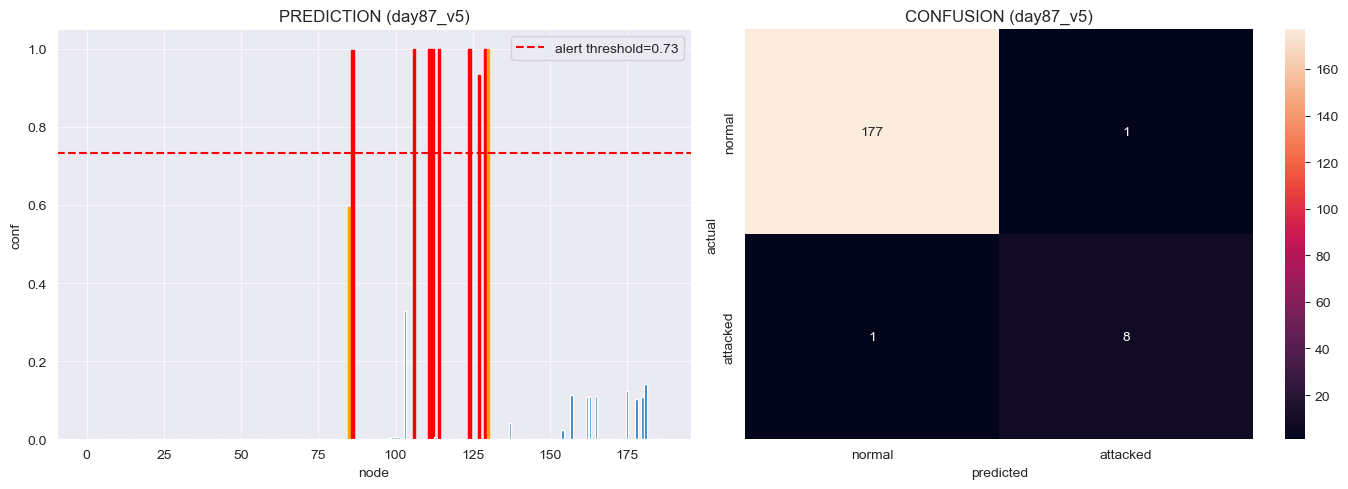

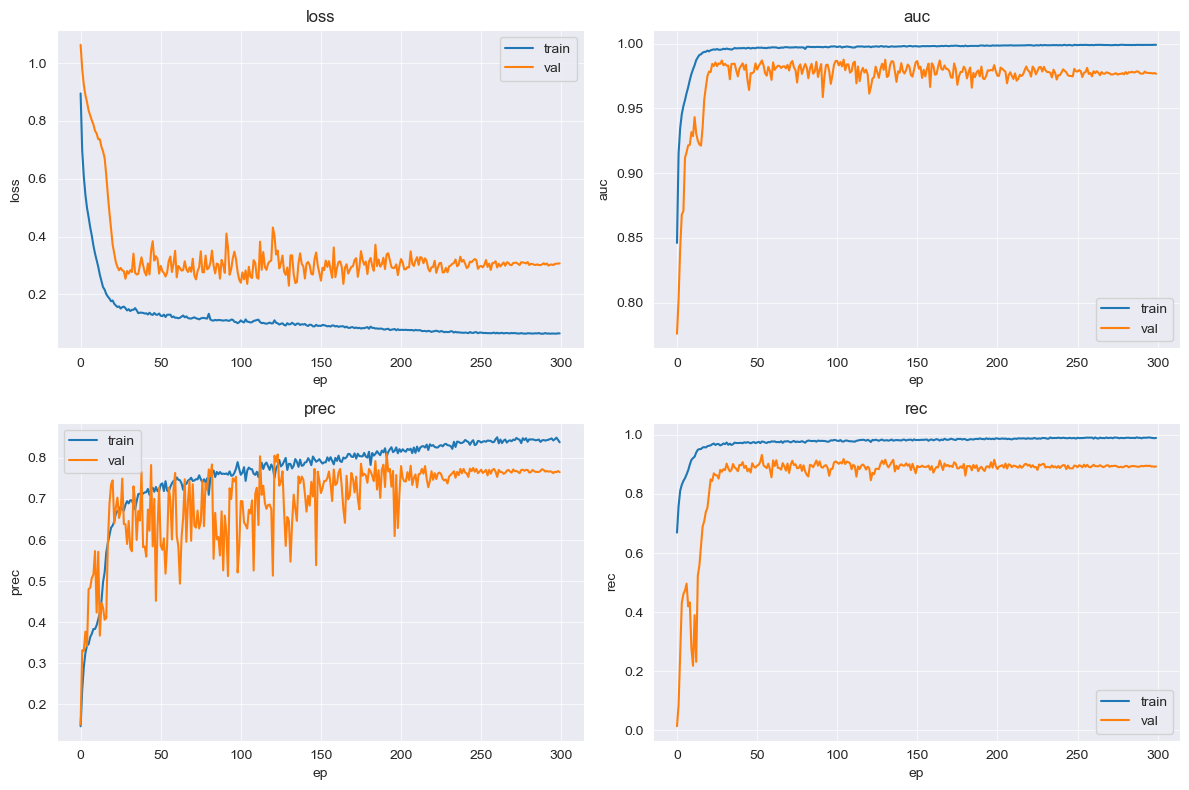

In [33]:
thresh = np.linspace(0.4, 0.9, 100) # find optimal threshold via maximizing f1 score
f1 = []
beta = 1.5 # importance of recall vs precision

for t in thresh:
    y_bin = (y_pred > t).astype(int)
    tp = ((y_bin == 1) & (y_test == 1)).sum()
    fp = ((y_bin == 1) & (y_test == 0)).sum()
    fn = ((y_bin == 0) & (y_test == 1)).sum()
    p = tp / (tp + fp + 1e-8)
    r = tp / (tp + fn + 1e-8)
    f1.append((1 + beta**2) * (p * r) / ((beta**2 * p) + r + 1e-8))

thresh_opt = thresh[np.argmax(f1)]
y_pred_bin = (y_pred > thresh_opt).astype(int)

print(f"\nTop 15 suspicious nodes (avg score across {X_test.shape[0]} test days):")
node_scores = y_pred.mean(axis=0)
for n in np.argsort(node_scores)[-15:][::-1]:
    attacked_str = '[ATTACK]' if y_test[:, n].sum() > 0 else ''
    print(f"  {n + 1}: {node_scores[n]:.3f} {attacked_str}")
print("\nClassification Report")
print(classification_report(y_test.flatten(), y_pred_bin.flatten(), target_names=['normal', 'attack']))

# visualization
idx = 101
day = d_test[idx]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
bars = axes[0].bar(range(N_NODES), y_pred[idx])
axes[0].axhline(thresh_opt, c='r', ls='--', label=f'alert threshold={thresh_opt:.2f}')
attacked_nodes_idx = np.where(y_test[idx] == 1)[0]
for i in np.argsort(y_pred[idx])[-10:]:
    bars[i].set_color('red' if i in attacked_nodes_idx else 'orange')
axes[0].set(xlabel='node', ylabel='conf', title=f'PREDICTION ({day})')
axes[0].legend()
axes[0].grid(alpha=0.7)

sns.heatmap(confusion_matrix(y_test[idx], y_pred_bin[idx]), fmt='d', annot=True, ax=axes[1])
axes[1].set(xlabel='predicted', ylabel='actual', title=f'CONFUSION ({day})')
axes[1].set_xticklabels(['normal', 'attacked'])
axes[1].set_yticklabels(['normal', 'attacked'])

plt.tight_layout()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, k in enumerate(['loss', 'auc', 'prec', 'rec']):
    ax = axes[i // 2, i % 2]
    ax.plot(hist.history[k], label='train')
    ax.plot(hist.history[f'val_{k}'], label='val')
    ax.set(xlabel='ep', ylabel=k, title=k)
    ax.legend()
    ax.grid(alpha=0.7)

plt.tight_layout()